In [1]:
import logging
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import math
import pandas as pd
import PIL.Image as Image
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from collections import OrderedDict
import torch
import torch.nn as nn
import PIL.Image as Image
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import pickle
from tqdm import tqdm_notebook as tqdm
import torchvision
import time
from collections import defaultdict
from torch.nn import CTCLoss
from Levenshtein import distance
import random
from torch.utils import data
from torch.utils.data import DataLoader

In [2]:
class ImageDataset(data.Dataset):
    """
    Dataset class for handwritten lines.

    Parameters
    ----------
    pickle_file : str
        Path to a dataset pickle file.
    meta : bool
        If True, meta data about files is provided.
    num_imgs : int, optional (default=-1)
        Choose only `num_imgs` imgs for processing. If set to -1, uses all available images.

    """

    def __init__(self, pickle_file, meta=False, num_imgs=-1, rescale_mode=True, padding_mode=False, 
                 rescale_size=(442, 64), padding_size=(1024,128)):
        with open(pickle_file, 'rb') as f:
            dataset = pickle.load(f)
        self.reference_dataset = dataset
        self.num_imgs = num_imgs
        self.rescale_mode = rescale_mode
        self.padding_mode = padding_mode
        self.rescale_size = rescale_size
        self.padding_size = padding_size
        if (self.num_imgs > 0) and (self.num_imgs < len(self.reference_dataset)):
            inds = np.random.choice(np.arange(len(self.reference_dataset)),
                                    self.num_imgs, replace=False)
            self.reference_dataset = [self.reference_dataset[i] for i in inds]
        self.meta = meta

    def __getitem__(self, idx):
        data = self.reference_dataset[idx]
        img = cv2.cvtColor(cv2.imread(data['img_path']), cv2.COLOR_BGR2RGB)/255.
        if self.rescale_mode:
            img = cv2.resize(img, self.rescale_size)
        elif self.padding_mode:
            img_shape = img.shape
            #print(img_shape)
            koef_1 = img_shape[1]/self.padding_size[0]
            koef_2 = img_shape[0]/self.padding_size[1]
            use_koef = max(koef_1, koef_2)
            if use_koef > 1.:
                img = cv2.resize(img, (math.floor(img_shape[1]/use_koef), math.floor(img_shape[0]/use_koef)))
                img_shape = img.shape
            padded_image = np.ones((self.padding_size[1], self.padding_size[0], img_shape[2]))
            #print(padded_image.shape)
            #print(img.shape)
            padded_image[0:img_shape[0], 0:img_shape[1], :] = img
            img = padded_image
            
        img = torch.from_numpy(img).permute(2,0,1).float()
        text = data['description']
        width = data['width']
        height = data['height']

        if self.meta:
            return img, text, data, width, height
        else:
            return img, text

    def __len__(self):
        return len(self.reference_dataset)
    
class strLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index
        #self.alphabet = alphabet

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1
    
    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.LongTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.LongTensor [n]: length of each text.
        """

        length = []
        result = []
        for item in text:            
#             item = item.decode('utf-8','strict')
            length.append(len(item))
            r = []
            for char in item:
                index = self.dict[char]
                # result.append(index)
                r.append(index)
            result.append(r)
        
        max_len = 0
        for r in result:
            if len(r) > max_len:
                max_len = len(r)
        
        result_temp = []
        for r in result:
            for i in range(max_len - len(r)):
                r.append(0)
            result_temp.append(r)

        text = result_temp
        return (torch.LongTensor(text), torch.LongTensor(length))


    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.LongTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.LongTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.LongTensor([l]), raw=raw))
                index += l
            return texts

In [3]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output
    
class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        cnn = nn.Sequential()

        def ConvBlock(in_c, out_c, k_s, padding, stride, dilation = 1, batchNorm=False, dropout = None, pooling = None, number = 0):
            
            cnn.add_module('conv{0}'.format(number),
                           nn.Conv2d(in_c, out_c, k_s, stride, padding, dilation))
            if batchNorm:
                cnn.add_module('batchnorm{0}'.format(number), nn.BatchNorm2d(out_c))
            cnn.add_module('relu{0}'.format(number), nn.ReLU(True))
            if dropout is not None:
                cnn.add_module('dropout{0}'.format(number), nn.Dropout2d(p=dropout))
            if pooling is not None:
                cnn.add_module('pooling{0}'.format(number), nn.MaxPool2d(*pooling))
        '''
        ConvBlock(in_c=nc, out_c=16, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = None, pooling = [2,2], number=0)
        ConvBlock(in_c=16, out_c=32, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.2, pooling = [2,2], number=1)
        ConvBlock(in_c=32, out_c=64, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.2, pooling = [2,2], number=2)
        ConvBlock(in_c=64, out_c=128, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = None, pooling = [2,2], number=3)
        ConvBlock(in_c=128, out_c=128, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.1, pooling = None, number=4)
        ConvBlock(in_c=128, out_c=256, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.1, pooling = None, number=5)
        #ConvBlock(in_c=128, out_c=256, k_s=3, padding=0, stride=1, 
                 # dilation = 1, batchNorm=True, dropout = None, pooling = None, number=6)
        ConvBlock(in_c=256, out_c=512, k_s=2, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = None, pooling = None, number=7)
        '''
        ConvBlock(in_c=nc, out_c=16, k_s=3, padding=1, stride=1, 
                  dilation = 1, batchNorm=True, dropout = None, pooling = [2,2], number=0)
        ConvBlock(in_c=16, out_c=32, k_s=3, padding=1, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.2, pooling = [2,2], number=1)
        ConvBlock(in_c=32, out_c=64, k_s=3, padding=1, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.2, pooling = None, number=2)
        ConvBlock(in_c=64, out_c=128, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = None, pooling = [2, 2], number=3)
        ConvBlock(in_c=128, out_c=128, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.1, pooling = None, number=4)
        ConvBlock(in_c=128, out_c=128, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.1, pooling = [2, 2], number=5)
        ConvBlock(in_c=128, out_c=256, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = None, pooling = None, number=6)
        ConvBlock(in_c=256, out_c=512, k_s=3, padding=0, stride=1, 
                  dilation = 1, batchNorm=True, dropout = None, pooling = None, number=7)
        
        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)
        
        # add log_softmax to converge output
        output = F.log_softmax(output, dim=2)

        return output


    def backward_hook(self, module, grad_input, grad_output):
        for g in grad_input:
            g[g != g] = 0   # replace all nan/inf in gradients to zero

In [4]:
def train_on_batch_rec(images, gt_text, model_crnn, ocr_loss, optimizer, device, batch_size, converter):

    model_crnn.train()
    
    pred_text = model_crnn(images.to(device))
    
    preds_size = torch.LongTensor([pred_text.size(0)] * batch_size)
    
    t_text, l_text = converter.encode(list(gt_text))
    
    loss = ocr_loss(pred_text, t_text, preds_size, l_text)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, decode_text = pred_text.max(2)
    decode_text = decode_text.transpose(1, 0).contiguous().view(-1)
    decode_text = converter.decode(decode_text.data, preds_size, raw=False)
    
    char_correct = 0
    total_char = 0
    for pred, gt in zip(decode_text, gt_text):
        for i, pred_char in enumerate(pred):
            if i<len(gt):
                if pred_char == gt[i]:
                    char_correct += 1
        total_char += len(gt)
            
    acc_char = (char_correct)/float(total_char)
    
    total_str = 0
    n_correct = 0
    cer = 0
    for pred, target in zip(decode_text, gt_text):
        if pred == target:
            n_correct += 1
        else:
            cer += distance(pred, target)/len(target)
        total_str+=1
            
    acc_str = (n_correct)/total_str
    cer = cer/total_str
    
    return (loss.item(), acc_char, acc_str, cer)

def val_on_batch_rec(images, gt_text, model_crnn, ocr_loss, device, batch_size, converter):

    model_crnn.eval()
    
    pred_text = model_crnn(images.to(device))
    
    preds_size = torch.LongTensor([pred_text.size(0)] * batch_size)
    
    t_text, l_text = converter.encode(list(gt_text))
    
    loss = ocr_loss(pred_text, t_text, preds_size, l_text)
    
    _, decode_text = pred_text.max(2)
    decode_text = decode_text.transpose(1, 0).contiguous().view(-1)
    decode_text = converter.decode(decode_text.data, preds_size, raw=False)
    
    char_correct = 0
    total_char = 0
    for pred, gt in zip(decode_text, gt_text):
        for i, pred_char in enumerate(pred):
            if i<len(gt):
                if pred_char == gt[i]:
                    char_correct += 1
        total_char += len(gt)
            
    acc_char = (char_correct)/float(total_char)
    
    total_str = 0
    n_correct = 0
    cer = 0
    for pred, target in zip(decode_text, gt_text):
        if pred == target:
            n_correct += 1
        else:
            cer += distance(pred, target)/len(target)
        total_str+=1
            
    acc_str = (n_correct)/total_str
    cer = cer/total_str
    
    _, preds = pred_text.max(2)
    preds = preds.transpose(1, 0).contiguous().view(-1)
    raw_preds = converter.decode(preds.data, preds_size, raw=True)
    
    return (loss.item(), acc_char, acc_str, cer, decode_text[:5], gt_text[:5], raw_preds[:5])

In [5]:
pickle_path_train = '/home/storage/3020/KrivorotovI/db/HKR/datasets/train.pkl'
pickle_path_val = '/home/storage/3020/KrivorotovI/db/HKR/datasets/val.pkl'
with open(pickle_path_train, 'rb') as f:
    full_dataset = pickle.load(f)
alphabet = ''
for example in full_dataset:
    alphabet += example['description']
alphabet = list(set(alphabet))
alphabet =''.join(alphabet)
len(alphabet)

79

In [6]:
imgH = 32 # the height of the input image to network
imgW = 100 # the width of the input image to network
nh = 256 # size of the lstm hidden state
nc = 3
nclass = len(alphabet)+1
batch_size = 64

In [7]:
device = torch.device("cuda:6")
converter = strLabelConverter(alphabet)
net = CRNN(imgH, nc, nclass, nh)
net.to(device)
ocr_loss = CTCLoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)
train_dataset = ImageDataset(pickle_path_train, num_imgs=-1, rescale_mode=False, padding_mode=True)
val_dataset = ImageDataset(pickle_path_val, num_imgs=-1, rescale_mode=False, padding_mode=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1, drop_last = True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1, drop_last = True)

torch.Size([64, 3, 128, 1024])
легкие летят


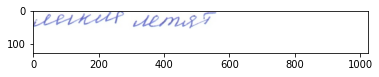

In [8]:
for imgs, text in train_dataloader:
    print(imgs.shape)
    plt.imshow(imgs[0].permute(1,2,0))
    print(text[0])
    break

In [ ]:
ep = 100

train_loss = []
train_acc_char = []
train_acc_str = []
train_cer = []

val_loss = []
val_acc_char = []
val_acc_str = []
val_cer = []

best_str_acc = 0

for epoch in range(ep):
    train_epoch_loss = []
    
    train_epoch_acc_char = []
    train_epoch_acc_str = []
    train_epoch_cer = []
    
    with tqdm(total = len(train_dataloader), ncols='100%') as bar_train:
        for i, (images, gt_text) in enumerate(train_dataloader):

            results = train_on_batch_rec(images, gt_text, net, ocr_loss, optimizer, device, batch_size, converter)
            loss, acc_char, acc_str, cer = results
            
            train_epoch_loss.append(loss)
            train_epoch_acc_char.append(acc_char)
            train_epoch_acc_str.append(acc_str)
            train_epoch_cer.append(cer)

            printed_data = f"Ep: {epoch}. Train loss: {np.mean(train_epoch_loss):.4f}.\
            Acc char: {np.mean(train_epoch_acc_char):.4f}.\
            Acc str: {np.mean(train_epoch_acc_str):.4f}.\
            CER: {np.mean(train_epoch_cer):.4f}."
            bar_train.set_description(printed_data)
            bar_train.update(1)
            
    train_loss.append(np.mean(train_epoch_loss))
    
    train_acc_char.append(np.mean(train_epoch_acc_char))
    train_acc_str.append(np.mean(train_epoch_acc_str))
    train_cer.append(np.mean(train_epoch_cer))
    
    
    val_epoch_loss = []
    
    val_epoch_acc_char = []
    val_epoch_acc_str = []
    val_epoch_cer = []
    
    with tqdm(total = len(val_dataloader), ncols='100%') as bar_val:
        for i, (images, gt_text) in enumerate(val_dataloader):

            results = val_on_batch_rec(images, gt_text, net, ocr_loss, device, batch_size, converter)
            loss, acc_char, acc_str, cer, decode_text, gt_text, raw_preds = results
            
            val_epoch_loss.append(loss)
            val_epoch_acc_char.append(acc_char)
            val_epoch_acc_str.append(acc_str)
            val_epoch_cer.append(cer)

            printed_data = f"Ep: {epoch}. Val loss: {np.mean(val_epoch_loss):.4f}.\
            Acc char: {np.mean(val_epoch_acc_char):.4f}.\
            Acc str: {np.mean(val_epoch_acc_str):.4f}.\
            CER: {np.mean(val_epoch_cer):.4f}."
            bar_val.set_description(printed_data)
            bar_val.update(1)
        
    val_loss.append(np.mean(val_epoch_loss))
    
    val_acc_char.append(np.mean(val_epoch_acc_char))
    val_acc_str.append(np.mean(val_epoch_acc_str))
    val_cer.append(np.mean(val_epoch_cer))
    
    print('Lr now:', optimizer.param_groups[0]['lr'])

    for raw_pred, pred, gt in zip(raw_preds, decode_text, gt_text):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt)) 
    
    if epoch == 40:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1
        print('Lr now:', optimizer.param_groups[0]['lr'])
        
    if epoch == 70:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1
        print('Lr now:', optimizer.param_groups[0]['lr'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Lr now: 0.001
А-------------------------------------------------------- => А                   , gt: Я стал              
А-------------------------------------------------------- => А                   , gt: Алматы              
А-------------------------------------------------------- => А                   , gt: Мерный круг         
К-------------------------------------------------------- => К                   , gt: бесполезны мольбы   
К-------------------------------------------------------- => К                   , gt: Карагандинская      



Lr now: 0.001
Н-к-и-я--  в-ба-р---------------------------------------- => Нкия вбар           , gt: Меня ветер          
но--- п-орзд-сии-нн-и--й--------------------------------- => но порздсиний       , gt: но нездешний        
У-р--о-ж---аа--тт----------  под-------ы----------------- => Урожат поды         , gt: ворошат корма       
на---  зж-о-в--о-й--- сстт-а-н-а------------------------- => на зжовой стана     , gt: На древней стене    
в- крро-с-н--о--й-- о--р-о--в-е-------------------------- => в кросной орове     , gt: в простой оправе    



Lr now: 0.001
К---------о------------з-а---х--с--к---а--н--с-кк-а---яя- => Козахсканская       , gt: ЮЖНО-КАЗАХСТАНСКАЯ  
Д----ж----н---------------------------------------------- => Джн                 , gt: Костанайская        
с--------е-------ж--------------------------------------- => сеж                 , gt: Ишака,              
В-д--н-о--хс---у------а---------------------------------- => Вднохсуа            , gt: Звучно стрелка      
К-о--р-а--г-а--н--д-и--н--с-к-а---я---------------------- => Корагандинская      , gt: Карагандинская      



Lr now: 0.001
по-л--я-н-ы---------------------------------------------- => поляны              , gt: поляны              
А---л--м----а----тт----ы--------------------------------- => Алматы              , gt: Алматы              
М-----о--и--  -р--уу-к---и------------------------------- => Мои руки            , gt: Мои руки            
Ж--а--м---бы--л-ь-с-к-а---я------------------------------ => Жамбыльская         , gt: Жамбыльская         
Ре--т-у-б-лии-ка----------------------------------------- => Ретублика           , gt: Республика          



Lr now: 0.001
и----  к-р-е-п-к--а-------------------------------------- => и крепка            , gt: и крепка            
Ус-т-ь-----К-а--м-еен-о- гго-р-ск------------------------ => Усть-Камено горск   , gt: Усть-Каменогорск    
К-о--м--у?? -Л--ю-б-е-м--у------------------------------- => Кому? Любему        , gt: Кому? Любому        
Р-а-ййо-н------------------------------------------------ => Район               , gt: Район               
Ш-ыы-м--к-е-н-тт----------------------------------------- => Шымкент             , gt: Шымкент             



Lr now: 0.001
Т--е-м-ии-р---------------------------------------------- => Темир               , gt: Темир               
к-л--я--т--в-о-й------  о-б-е--л-щ-а-лл------------------ => клятвой обелщал     , gt: клятвой обещал      
М--а--к-и--н-с-к----------------------------------------- => Макинск             , gt: Макинск             
Пуу-т-ь-  у-к-о--у-я------------------------------------- => Путь укоуя          , gt: Путь указуя         
М-а-Л--Д--а-В-И-Я---------------------------------------- => МаЛДаВИЯ            , gt: МОЛДАВИЯ            



Lr now: 0.001
Ж---т----------нннн-нн--н---н----н---н---тт-----------ссс => Жтннннннтс          , gt: Усть-Каменогорск    
К-----з-а-а-а--д-аа--а---тт-------ссссссссс-----------ттт => Кзааадаатст         , gt: Молдавия            
В--в------н----с----л--ннн-с--сссс---------------------кк => Ввнслнсск           , gt: Завтра к милой      
Ж---------ж------н---а--------х-----сс----------------ттт => Жжнахст             , gt: С высоты ледника    
В----т---ж-ж--------а--н-е----е-н---н----н------------ттт => Втжж-анеенннт       , gt: Западно Казахстанская



Lr now: 0.001
К-а-р--а-жж--а--л---------------------------------------- => Каражал             , gt: Каражал             
ст--у-д-е-н-о--и-  т--и--ш---и-ноо-и--------------------- => студенои тишинои    , gt: студенои тишинои    
К--и--р-а---т---а-у-------------------------------------- => Киратау             , gt: Каратау             
А---к---т--О--б---е-------------------------------------- => АктОбе              , gt: АКТОБЕ              
Б-а-йй--к-о--н--ы--р------------------------------------- => Байконыр            , gt: Байконыр            



Lr now: 0.001
М--о-лл-д-а--в-и--я-------------------------------------а => Молдавияа           , gt: Молдавия            
Гз-а--  -т-е-л---гг-о--й--------------------------------а => Гза телгойа         , gt: за телегой          
Узззбб-е-к---е-сс-тт--а--н------------------------------- => Узбекестан          , gt: Узбекистан          
С-тт---е-п--нн---я----я---------------------------------а => Степняяа            , gt: Степняк             
А--лл-мм---а---т---ы------------------------------------- => Алматы              , gt: Алматы              



Lr now: 0.001
Н--е--   в-м-е-с-т--е------------------------------------ => Не вместе           , gt: Не вместе           
К--о-сс-т-а---н---а---й---------------------------------- => Костанай            , gt: Костанай            
Не--  жж-а--лее-й---  к-о-н-я--,------------------------- => Не жалей коня,      , gt: Не жалей коня,      
я-зз-в--и----т-е---л--ь---н--ыы---м------  с-в-о--иии,мхм => язвительным свои,мхм, gt: язвительным своим.  
Т---ы---  с-т--а-л-а---  ввнноо-вь----------------------- => Ты стала вновь      , gt: Ты стала вновь      



Lr now: 0.001
о -н-е-ж--н-о-с--т--и-,  о- с-л--а-в--у-----------------  => о нежности, о славу , gt: о нежности, о славе,
В--  сыы-р--у--о----н--о-ч-ь-------   ------------------- => В сыруоночь         , gt: В сырую ночь        
м--о-ж--н-о-- с-о-с-т-а--в-и-т--ь- гго-р-о-д------------  => можно составить город , gt: можно составить город
Л-е-т--и------с-т--рр-о-----а-------    ----------------- => Летистроа           , gt: ротив строгих       
и- -осс-к-а-л--и-в--  п-а---т-ь-------------------------  => и оскалив пать      , gt: и оскалив пасть     



Lr now: 0.001
не-п-о-д-а-т-ллии-в-у-ю--   м--аа-т-ь-------------------- => неподатливую мать   , gt: неподатливую мать   
и  о--д-н-и-им-  п-ро--б-у-ж--д-ет-.--------------------- => и одниим пробуждет. , gt: и одним пробужден,  
Ш-----ы--м--к-е-н--т------------------------------------- => Шымкент             , gt: Шымкент             
О---с--а---к--о--р--о-- в--к---а------------------------- => Осакоро вка         , gt: Осакоровка          
Та-к---  ввс-к------------------------------------------- => Так вск             , gt: Так век             



Lr now: 0.001
Узз--а-е-т--и--с--т--а--н-------------------------------- => Узаетистан          , gt: Узбекистан          
Г----д-е-т-  хоовва-р-т-а-------------------------------я => Гдет ховартая       , gt: Людей коварны       
Л--е-р--н--о--й--- к-р--уу-л----------------------------- => Лерной крул         , gt: Мерный круг         
То-т---н-я--м-ии---  к-р-о-в-ь--------------------------я => Тотнями кровья      , gt: Толчками кровь,     
Г--е-рра--нн-о----вс---на-е-----------------------------я => Герановснаея        , gt: Прекрасно в нас     



Lr now: 0.001
Во----в-о------о---щ-а-----------------------ииииии--ссаа => Вовоощаиса          , gt: во все концы,       
К-а--з-а-х-сс-т--а--нн--------------------------------сяя => Казахстанся         , gt: Казахстан           
Ж-----о-с------ес--тт---иы------------кт--а-----------яяя => Жосестиыктая        , gt: проклятым роем      
Севеер--н-о-------К--о-ззаа-х-сст-а--н-кккаяяя-яя-----яяя => СеверноКозахстанкаяяя, gt: Северно-Казахстанская
Ж---с-т------------о---т---ь-----с-----о-кк---кк------ияя => Жстотьсоккия        , gt: УСТЬ-КАМЕНОГОРСК    



Lr now: 0.001
св-оя--  соов-ер------а----,---------------------------яя => своя совера,я       , gt: свой совершит       
И--  п-о-----з-р--ы-т--м--уу--------------------------ооя => И позрытмуоя        , gt: И по изрытму        
С-т--е---п--п----я---к---------кккккк----ккккккккк-----яя => Степпякккя          , gt: Степняк             
П-о-л-с-к-а-м-и--  кр-о-в--,----------------------------а => Полсками кров,а     , gt: Толчками кровь,     
К-е-м-----р--а-----------------------------------------яя => Кемрая              , gt: Темир               



Lr now: 0.001
У-с-тт--ьь----к-а---м---н--огг--ор-сскк------------------ => Усть-камногорск     , gt: Усть-Каменогорск    
П-а---  д-арро-гее-    з-и-м--не-й----------------------- => Па дароге зимней    , gt: По дороге зимней    
но-вве--т--  г-ер-де-нно---,----------------------------- => новет гердено,      , gt: твоей гордыне       
П-ее-т-рро-п-а-ввлл-о-всскк------------------------------ => Петропавловск       , gt: Петропавловск       
Ж---а--м--бы-ллсск-а-яя---------------------------------- => Жамбылская          , gt: Жамбылская          



Lr now: 0.001
К--а--р-а-г-аа--н---д-ы-н--сскк-о---я------------------ии => Карагандынскояи     , gt: Карагандинская      
А---тт----н--о------------------------------------------ш => Атнош               , gt: Астана              
П-роо-ж--л-оо-- п--я-тт-ь-- п-е-т---о-------------------- => Прожло пять пето    , gt: Прошло пять лет,    
А---т-ыы-р-о---у----------------------------------------ш => Атыроуш             , gt: Атырау              
Л--е-п--яя-т-----ии--ик--и----щи------------------------, => Лепятиикищи,        , gt: Летят шмели         



Lr now: 0.001
и-гг-р--ы---  п--о-д--в-ы---в-  с-вв-о--л--,,------------ => игры подвыв свол,   , gt: игры позавыв свои,  
Протти-в--  ссттро-иик----------------------------------- => Против строик       , gt: Против строгих      
Т---уурркк-е-с-тт---а---нн-сскк-а---я-------------------- => Туркестанская       , gt: Туркестанская       
Злл-ы--е------------------------------------------------- => Злые                , gt: Злые                
И--  с--к-л--а--дд-ы-в-а--юю-тт-------------------------- => И складывают        , gt: И складывают        



Lr now: 0.001
За--ч-аа-г-а---н-сскк------------------------------------ => Зачаганск           , gt: Зачаганск           
А--к--тт--а--у------------------------------------------- => Актау               , gt: Актау               
И-   з-ваа-л--------------------------------------------- => И звал              , gt: И звал              
П--рро-л-е-тт-еввшш--ии-й-------------------------------- => Пролетевший         , gt: Пролетевший         
в-ходди-лл-а-- жж--а--ж---д-а----   м-оо-с-тиии---------- => входила жажда мости , gt: входила жажда мести 



Lr now: 0.001
оп-я-т--ь------------------------------------------------ => опять               , gt: опять               
М-О-Л--Д--А-В--И-Я--------------------------------------- => МОЛДАВИЯ            , gt: МОЛДАВИЯ            
Са-р-ы-а-гга--ш------------------------------------------ => Сарыагаш            , gt: Сарыагаш            
Ри--д-де-р----------------------------------------------- => Риддер              , gt: Риддер              
во-л-н-ы--  м--о-р-е-й-..-------------------------------- => волны морей.        , gt: волны морей.        



Lr now: 0.001
м-о-жж-н--о-  соос-т--а-в-и-тт--ь--  ггорро-дд----------- => можно составить город, gt: можно составить город
Л-у-г-а--м--и---  ка--т-я--т-с-яя------------------------ => Лугами катятся      , gt: Лугами катятся      
К--оо-с-т-а-н--а---йй------------------------------------ => Костанай            , gt: Костанай            
об-лл-.-------------------------------------------------- => обл.                , gt: обл.                
А--б--аа--йй--------------------------------------------- => Абай                , gt: Абай                



Lr now: 0.001
П-рро-хо-д-яя-т- с--------------------------------------- => Проходят с          , gt: Проходят с          
За-пп-а-д-нно-----КК-ааззаахххсссттт--а-нннссскк--а--яя-- => Западно-Казахстанская, gt: Западно-Казахстанская
Коостт--а-нна--й----------------------------------------- => Костанай            , gt: Костанай            
и рруус-ск-ии-е-   п-о-лляя-н--ы------------------------- => и русские поляны    , gt: и русские поляны    
К-ыы-ззыы-л-оорр--д--а----------------------------------- => Кызылорда           , gt: Кызылорда           



Lr now: 0.001
Ок-с-т--ы---с-к--а---а-зз-------------------------------- => Окстыскааз          , gt: Опять стога,        
Узззббе-к-ии-стта--н--с---------------------------------- => Узбекистанс         , gt: Узбекистан          
п----ез-----------о---л--о-----и------------------------- => пезолои             , gt: пред аналоем,       
он--у-вви--д-е-я----в--о-ллк--а--т----------------------, => онувидеяволкат,     , gt: он увидел волка,    
т---в-о---й---  з-о--р-д-ыы-н-е-------------------------– => твой зордыне–       , gt: твоей гордыне       



Lr now: 0.001
в-о--й--о--н--------------------------------------------и => войони              , gt: Район               
Ж----а--р--к--е-н--тт---а-------------------------------с => Жаркентас           , gt: Жаркент             
д-ж--ии-г-и-тт--т--------ссссссссс----------------------я => джигиттся           , gt: джигит,             
С--у--ч---о--лл-----------------------------------------я => Сучоля              , gt: Скучно              
М---о-ллдда-б-и-яя--------------------------------------я => Молдабияя           , gt: Молдавия            



Lr now: 0.001
Еггоо---  жж-ии-ввии-тт--,------------------------------- => Его живит,          , gt: Его живит,          
Р--К----------------------------------------------------- => РК                  , gt: РК                  
Ра-йй-о-н------------------------------------------------ => Район               , gt: Район               
К--а-з-а--х-с-тт--а-нн----------------------------------- => Казахстан           , gt: Қазахстан           
Вы--д--  по-с--т--о--я-л-о-г-о--------------------------- => Выд постоялого      , gt: Вид постоялого      



Lr now: 0.001
Стт-о-пп--в-п-е-мм--е---м--м---------т----------ссс---ттт => Стопвпемеммтст      , gt: Что время лечит     
сезммр-е-ж--ноо---------------------------------------ттт => сезмрежнот          , gt: и крепка.           
горрессст--но--б----зе-мм-----нх----------------------ттт => горестнобземнхт     , gt: горестной земле,    
Ж--к--т----а---уу-------------------------------------ття => Жктаутя             , gt: Актау               
К--о-р--я----и---------а--я--а-аа-н-------------сс----сся => Коряиаяаансся       , gt: моряки глядят.      



Lr now: 0.001
со-зн-а-н-ии-я-  ббе-с-сии-л-ь-я------------------------- => сознания бессилья   , gt: сознания бессилья   
К-о-с--т--а--н-аа--й------------------------------------- => Костанай            , gt: Костанай            
к-а--к-ии-хх--  -у-жж-е----  н---е--т----;--------------- => каких уже нет;      , gt: каких уж нет;       
П--а--ввлл-оо-дд-аа-р------------------------------------ => Павлодар            , gt: Павлодар            
А-кк-тт---ююббии-н-сскк-а--я----------------------------- => Актюбинская         , gt: Актюбинская         



Lr now: 0.001
ж-и--л  уу  м--о-рр-я-.---------------------------------- => жил у моря.         , gt: жил у моря,         
Т-урркесстаа-н------------------------------------------- => Туркестан           , gt: Туркестан           
П----а--в--лл--одд-а--р-сс-к---а--я---------------------- => Павлодарская        , gt: Павлодарская        
З-е-м--л-яя- дд-у-шшии-с-т-а----------------------------- => Земля душиста       , gt: Земля душиста       
Б-оллььшшш-у--ю------------------------------------------ => Большую             , gt: Большую             



Lr now: 0.001
А--к----а---м-------------------------------------------я => Акамя               , gt: Аксаи               
П-о- д-оррогге-  з-и-м--н-е-й--м-----------------------ии => По дороге зимнейми  , gt: По дороге зимней,   
А--к-т--а--уу------------------------------------------сс => Актаус              , gt: Актау               
вы--с-и--т--------мм-----------------------------------ае => выситмае            , gt: выси,               
А---б-х--а-з-и---я-------------------------------------аа => Абхазияа            , gt: Абхазия             
